In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.externals import joblib

from helpfunction import sciNot

%matplotlib inline
gr      = 1.618

In [2]:
min_dedx_hits=5
pd.options.display.max_columns = 999

# Tracks

In [3]:
input_tr = ['../Input/XGBoost/nue/trackFrame_nue0.pckl',
            '../Input/XGBoost/nue/trackFrame_nue1.pckl',
            '../Input/XGBoost/nue/trackFrame_nue2.pckl',
            '../Input/XGBoost/nue/trackFrame_nue3.pckl',
            '../Input/XGBoost/nue/trackFrame_nue4.pckl',
            
            '../Input/XGBoost/nu/trackFrame_nu0.pckl',
            '../Input/XGBoost/nu/trackFrame_nu1.pckl',
            '../Input/XGBoost/nu/trackFrame_nu2.pckl',
            
           # '../Input/XGBoost/intime/trackFrame_intime.pckl'
           ]

input_test = ['../Input/XGBoost/nue/trackFrame_nue5.pckl',
            '../Input/XGBoost/nue/trackFrame_nue6.pckl',
            '../Input/XGBoost/nue/trackFrame_nue7.pckl',
            '../Input/XGBoost/nue/trackFrame_nue8.pckl',
            '../Input/XGBoost/nue/trackFrame_nue9.pckl',
            
            '../Input/XGBoost/nu/trackFrame_nu3.pckl',
            '../Input/XGBoost/nu/trackFrame_nu4.pckl',
            '../Input/XGBoost/nu/trackFrame_nu5.pckl',
            '../Input/XGBoost/nu/trackFrame_nu6.pckl',
            '../Input/XGBoost/nu/trackFrame_nu7.pckl',
            '../Input/XGBoost/nu/trackFrame_nu8.pckl',
            '../Input/XGBoost/nu/trackFrame_nu9.pckl'
           ]


#input_tr_data = ['../Input/XGBoost/bnb/trackFrame_data_bnb.pckl',
#                 '../Input/XGBoost/bnbext/trackFrame_data_bnbext.pckl'
#                ]

intput_tr_df = [ pd.read_pickle(x) for x in input_tr]
df_tr_train = pd.concat(intput_tr_df,ignore_index=True,copy=False) 
df_tr_train['track_dedx_med'] = df_tr_train['track_dedx']*df_tr_train['track_dedx_cali']

intput_tr_df = [ pd.read_pickle(x) for x in input_test]
df_tr_test = pd.concat(intput_tr_df,ignore_index=True,copy=False) 
df_tr_test['track_dedx_med'] = df_tr_test['track_dedx']*df_tr_test['track_dedx_cali']

columns_track_XGB = ['track_dedx_med', 'track_dedx_avg', 'track_pca',
                     'predict_em', 'predict_mu', 'predict_cos', 'predict_pi', 'predict_p',
                     'track_length', 'track_vtx', 'track_vtx_end',
                     'track_sh_daughter', 'track_tr_daughter',
                     'track_is_tr_daughter','track_is_sh_daughter',
                     'track_hits_ratio',
                     'track_dedx_hits','track_multi_daughter','track_containment','track_maxangle'
                    ] 

In [4]:
df_tr_train.head()

,matched_tracks_energy,predict_cos,predict_em,predict_mu,predict_p,predict_pi,track_cali,track_dedx,track_dedx_avg,track_dedx_cali,track_dedx_hits,track_energy,track_hits_ratio,track_is_daughter,track_maxangle,track_pca,true_e_cl,track_containment,track_is_sh_daughter,track_is_tr_daughter,track_length,track_multi_daughter,track_sh_daughter,track_tr_daughter,track_vtx,track_vtx_end,true_e,true_mu,track_dedx_med
0,1.713227,0.782227,0.034882,0.043518,0.033051,0.106445,0.999570,0.031582,1.558769,1.007304,10.0,0.201112,0.916129,0.0,-0.996257,0.992676,False,True,False,False,75.950256,False,False,False,0.729088,76.498567,False,True,0.031813
1,1.713227,0.966309,0.000108,0.011604,0.005184,0.017029,1.031534,0.228841,1.953827,0.998097,9.0,0.083273,0.925373,0.0,-0.996257,0.998047,False,False,False,False,44.018329,False,False,False,1.016908,44.745610,False,True,0.228406
2,0.189395,0.002941,0.123901,0.088318,0.197632,0.587402,1.025278,4.420248,0.437338,1.022480,14.0,0.031828,0.913043,0.0,0.117343,0.973633,False,True,False,False,6.964562,False,True,False,1.783083,8.739637,False,False,4.519613
3,1.021722,0.004524,0.036804,0.121887,0.511719,0.324951,1.013823,0.827561,0.844236,1.020149,12.0,0.026997,0.750000,0.0,-0.038877,0.957520,False,True,False,False,4.816481,False,False,False,1.937041,3.966485,False,False,0.844236
4,1.207423,0.000477,0.000710,0.001399,0.996582,0.000714,0.962405,3.335614,3.241258,0.971713,14.0,0.149066,0.965116,0.0,0.278506,0.997070,False,True,False,False,41.024646,False,False,False,0.049999,41.054048,False,False,3.241258


In [32]:
# For now, quick fix: require at least two hits in track_dedx_hits, otherwise track_dedx is nonsence.
df_tr_train = df_tr_train[df_tr_train['track_dedx_hits']>=min_dedx_hits]
df_tr_test = df_tr_test[df_tr_test['track_dedx_hits']>=min_dedx_hits]

df_tr_train.head()
print(df_tr_train.columns)

Index(['matched_tracks_energy', 'predict_cos', 'predict_em', 'predict_mu',
       'predict_p', 'predict_pi', 'track_cali', 'track_dedx', 'track_dedx_avg',
       'track_dedx_cali', 'track_dedx_hits', 'track_energy',
       'track_hits_ratio', 'track_is_daughter', 'track_maxangle', 'track_pca',
       'true_e_cl', 'track_containment', 'track_is_sh_daughter',
       'track_is_tr_daughter', 'track_length', 'track_multi_daughter',
       'track_sh_daughter', 'track_tr_daughter', 'track_vtx', 'track_vtx_end',
       'true_e', 'true_mu', 'track_dedx_med'],
      dtype='object')


In [33]:
X_train = df_tr_train[columns_track_XGB].as_matrix()
X_test  = df_tr_test[columns_track_XGB].as_matrix()

Y_train = df_tr_train[['true_mu','true_e','true_e_cl']]
Y_test = df_tr_test[['true_mu','true_e','true_e_cl']]

In [34]:
# fit model no training data
label = 'true_mu'
model = XGBClassifier()
model.fit(X_train, Y_train[label])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_tr_mu.pkl') 
y_pred_mu = model.predict_proba(X_test)
y_pred_mu_train = model.predict_proba(X_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.90      0.93      0.91    182561
       True       0.93      0.91      0.92    210261

avg / total       0.92      0.92      0.92    392822

Feature ranking:
1. feature predict_cos(0.152080)
2. feature predict_p(0.146341)
3. feature track_maxangle(0.107604)
4. feature predict_pi(0.083214)
5. feature predict_em(0.077475)
6. feature track_vtx(0.076040)
7. feature predict_mu(0.058824)
8. feature track_vtx_end(0.041607)
9. feature track_length(0.040172)
10. feature track_is_sh_daughter(0.038737)
11. feature track_tr_daughter(0.035868)
12. feature track_is_tr_daughter(0.034433)
13. feature track_sh_daughter(0.030129)
14. feature track_pca(0.018651)
15. feature track_hits_ratio(0.017217)
16. feature track_dedx_med(0.014347)
17. feature track_dedx_avg(0.012912)
18. feature track_multi_daughter(0.007174)
19. feature track_dedx_hits(0.005739)
20. feature track_containment(0.001435)


In [35]:
# fit model no training data
label = 'true_e'
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_tr_e.pkl') 
y_pred_e = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.98      1.00      0.99    384471
       True       0.57      0.29      0.39      8351

avg / total       0.98      0.98      0.98    392822

Feature ranking:
1. feature predict_em(0.165951)
2. feature track_sh_daughter(0.108727)
3. feature track_length(0.084406)
4. feature track_maxangle(0.078684)
5. feature track_vtx(0.078684)
6. feature track_dedx_med(0.064378)
7. feature track_is_sh_daughter(0.061516)
8. feature track_hits_ratio(0.057225)
9. feature predict_cos(0.051502)
10. feature track_dedx_avg(0.047210)
11. feature predict_p(0.045780)
12. feature track_vtx_end(0.040057)
13. feature predict_pi(0.031474)
14. feature track_multi_daughter(0.022890)
15. feature track_dedx_hits(0.020029)
16. feature track_pca(0.012876)
17. feature track_tr_daughter(0.011445)
18. feature predict_mu(0.010014)
19. feature track_is_tr_daughter(0.005722)
20. feature track_containment(0.001431)


In [36]:
# fit model no training data
label = 'true_e_cl'
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_tr_cle.pkl') 
y_pred_cle = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.99      1.00      0.99    387924
       True       0.65      0.37      0.47      4898

avg / total       0.99      0.99      0.99    392822

Feature ranking:
1. feature predict_em(0.167143)
2. feature track_sh_daughter(0.114286)
3. feature track_vtx(0.088571)
4. feature track_hits_ratio(0.088571)
5. feature track_length(0.082857)
6. feature track_maxangle(0.075714)
7. feature track_dedx_avg(0.051429)
8. feature track_dedx_med(0.048571)
9. feature track_vtx_end(0.042857)
10. feature track_dedx_hits(0.038571)
11. feature track_multi_daughter(0.038571)
12. feature predict_p(0.037143)
13. feature track_is_sh_daughter(0.021429)
14. feature predict_pi(0.021429)
15. feature predict_cos(0.020000)
16. feature track_pca(0.020000)
17. feature track_tr_daughter(0.012857)
18. feature predict_mu(0.012857)
19. feature track_is_tr_daughter(0.011429)
20. feature track_containment(0.005714)


Cut value: 0.13 removes 98.1 % of muon tagged tracks and 24.1 % of not-muon tagged tracks.
Cut value: 0.7 keeps 13.9 % of electron tagged tracks and 0.1 % of not-electron tagged tracks.
Cut value: 0.7 keeps 21.8 % of closest electron tagged tracks and 0.1 % of not-closest-electron tagged tracks.


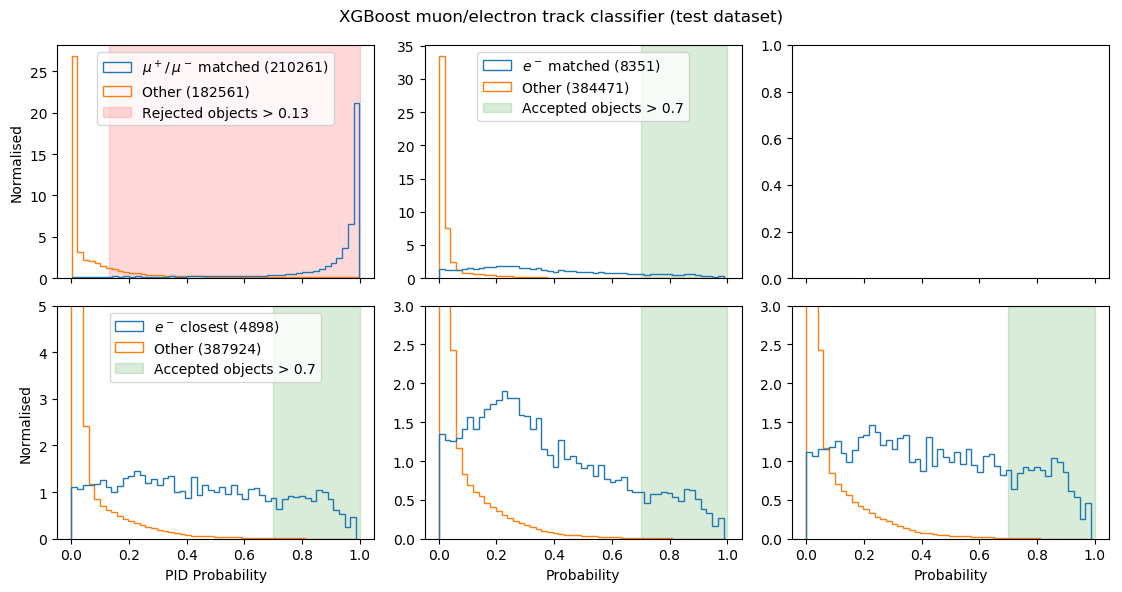

In [38]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r'XGBoost muon/electron track classifier (test dataset)')
N=50
muon_cut = 0.13
electron_cut=0.7
close_e_cut=0.7


# Electron track classification
y_test_e = Y_test['true_e']
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron track classification
y_test_cle = Y_test['true_e_cl']
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon track classification
y_test_mu = Y_test['true_mu']
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/ \:\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')
label_cl_e=(r'$e^-$ closest ('+str(len(arr_cl_e))+')','Other ('+str(len(arr_cl_ne))+')')

ax[0][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[0][0].set_ylabel('Normalised')


#ax[1][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
#ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[1][0].set_ylim(0,5)
ax[1][0].set_ylabel('Normalised')
ax[1][0].set_xlabel('PID Probability')

ax[0][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)

ax[1][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,3)
ax[1][1].set_xlabel('Probability')


ax[1][0].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[1][0].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)

ax[1][2].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,3)
ax[1][2].set_xlabel('Probability')

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[1][0].get_legend_handles_labels()
ax[1][0].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('../Output/XGB_track.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged tracks and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged tracks.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of electron tagged tracks and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-electron tagged tracks.')

print('Cut value:',close_e_cut,'keeps', sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),'% of closest electron tagged tracks and',
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),'% of not-closest-electron tagged tracks.')


In [11]:
# Question: how many tracks have a muon score of lower than muon cut, 
# have an electron score higher than electron_cut and are not an electron.
print(sum( (y_pred_mu[:,1]<muon_cut)*(y_pred_e[:,1]>electron_cut)*(y_test_e==0)))
print(sum( (y_pred_mu[:,1]<muon_cut)*(y_test_e==0)))


126
138070


/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


# Showers

In [12]:
input_sh = ['../Input/XGBoost/nue/showerFrame_nue0.pckl',
            '../Input/XGBoost/nue/showerFrame_nue1.pckl',
            '../Input/XGBoost/nue/showerFrame_nue2.pckl',
            '../Input/XGBoost/nue/showerFrame_nue3.pckl',
            '../Input/XGBoost/nue/showerFrame_nue4.pckl',
            
            '../Input/XGBoost/nu/showerFrame_nu0.pckl',
            '../Input/XGBoost/nu/showerFrame_nu1.pckl',
            '../Input/XGBoost/nu/showerFrame_nu2.pckl'
            
            #'../Input/XGBoost/intime/showerFrame_intime.pckl'
           ]

input_sh_test = [
                 '../Input/XGBoost/nu/showerFrame_nu3.pckl',
                 '../Input/XGBoost/nu/showerFrame_nu4.pckl',
                 '../Input/XGBoost/nu/showerFrame_nu5.pckl',
                 '../Input/XGBoost/nu/showerFrame_nu6.pckl',
                 '../Input/XGBoost/nu/showerFrame_nu7.pckl',
                 '../Input/XGBoost/nu/showerFrame_nu8.pckl',
                 '../Input/XGBoost/nu/showerFrame_nu9.pckl',
                
                 '../Input/XGBoost/nue/showerFrame_nue5.pckl',
                 '../Input/XGBoost/nue/showerFrame_nue6.pckl',
                 '../Input/XGBoost/nue/showerFrame_nue7.pckl',
                 '../Input/XGBoost/nue/showerFrame_nue8.pckl',
                 '../Input/XGBoost/nue/showerFrame_nue9.pckl',
                 
                ]


#input_sh_data = ['../Input/XGBoost/bnb/showerFrame_data_bnb.pckl',
#                 '../Input/XGBoost/bnbext/showerFrame_data_bnbext.pckl'
#                ]

intput_sh_df = [ pd.read_pickle(x) for x in input_sh]
df_sh_train = pd.concat(intput_sh_df,ignore_index=True,copy=False) 
df_sh_train['shower_dedx_med'] = df_sh_train['shower_dedx']*df_sh_train['shower_dedx_cali']

intput_sh_df = [ pd.read_pickle(x) for x in input_sh_test]
df_sh_test = pd.concat(intput_sh_df,ignore_index=True,copy=False) 
df_sh_test['shower_dedx_med'] = df_sh_test['shower_dedx']*df_sh_test['shower_dedx_cali']

columns_shower_XGB = [ 'shower_dedx_med', 'shower_dedx_avg', 'shower_dedx_hits', 'shower_pca',
                       'shower_open_angle', 'shower_length', 'shower_vtx', 'shower_containment_q','shower_sp_profile', 
                       #'shower_sh_daughter','shower_tr_daughter', 'shower_multi_daughter',
                       'shower_is_sh_daughter','shower_is_tr_daughter','shower_maxangle',
                       'shower_hits_ratio']

In [13]:
df_sh_train.head()

,matched_showers_energy,shower_cali,shower_containment_q,shower_dedx,shower_dedx_avg,shower_dedx_cali,shower_dedx_hits,shower_energy,shower_hits_ratio,shower_is_daughter,shower_length,shower_maxangle,shower_open_angle,shower_pca,shower_sp_profile,true_e_cl,shower_is_sh_daughter,shower_is_tr_daughter,shower_multi_daughter,shower_sh_daughter,shower_tr_daughter,shower_vtx,true_e,true_mu,shower_dedx_med
0,0.449508,1.020817,0.999999,9.639873,0.074240,1.028810,15.0,0.186847,0.418301,0.0,126.625000,-0.010344,0.409668,0.979004,4.562500,False,False,False,False,False,False,26.196456,True,False,9.917601
1,0.014413,0.983531,0.999999,0.051451,0.099594,0.982037,3.0,0.011100,1.000000,0.0,8.742188,-0.010344,0.246094,0.896484,4.562500,False,False,False,False,False,False,109.467255,False,False,0.050527
2,0.290183,1.020635,0.999999,2.501584,2.513355,1.013243,9.0,0.023806,0.695652,0.0,13.664062,0.626174,0.217773,0.966797,4.562500,False,False,False,False,False,False,102.435099,False,False,2.534713
3,1.411137,0.985159,0.998139,1.837477,1.814891,0.987708,11.0,1.206001,0.823409,0.0,152.375000,-0.308704,0.121216,0.944336,3.383084,True,False,False,False,False,False,64.182654,True,False,1.814891
4,1.411137,0.976966,0.998139,4.502869,2.811380,0.983079,8.0,0.073133,0.785714,0.0,20.500000,-0.311641,0.458008,0.821777,3.383084,False,False,False,False,False,False,160.130771,True,False,4.426677


In [14]:
# For now, quick fix: require at least two hits in track_dedx_hits, otherwise track_dedx is nonsence.
df_sh_train = df_sh_train[df_sh_train['shower_dedx_hits']>=min_dedx_hits]
df_sh_test = df_sh_test[df_sh_test['shower_dedx_hits']>=min_dedx_hits]

df_sh_train.head()
print(df_sh_train.columns)

Index(['matched_showers_energy', 'shower_cali', 'shower_containment_q',
       'shower_dedx', 'shower_dedx_avg', 'shower_dedx_cali',
       'shower_dedx_hits', 'shower_energy', 'shower_hits_ratio',
       'shower_is_daughter', 'shower_length', 'shower_maxangle',
       'shower_open_angle', 'shower_pca', 'shower_sp_profile', 'true_e_cl',
       'shower_is_sh_daughter', 'shower_is_tr_daughter',
       'shower_multi_daughter', 'shower_sh_daughter', 'shower_tr_daughter',
       'shower_vtx', 'true_e', 'true_mu', 'shower_dedx_med'],
      dtype='object')


In [15]:
X_train = df_sh_train[columns_shower_XGB].as_matrix()
X_test  = df_sh_test[columns_shower_XGB].as_matrix()

Y_train = df_sh_train[['true_mu','true_e','true_e_cl']]
Y_test = df_sh_test[['true_mu','true_e','true_e_cl']]

In [16]:
# fit model no training data
label = 'true_mu'
model = XGBClassifier()
model.fit(X_train, Y_train[label])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_sh_mu.pkl') 
y_pred_mu = model.predict_proba(X_test)
y_pred_mu_train = model.predict_proba(X_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.82      0.90      0.86    175036
       True       0.76      0.61      0.67     86868

avg / total       0.80      0.81      0.80    261904

Feature ranking:
1. feature shower_containment_q(0.167143)
2. feature shower_length(0.138571)
3. feature shower_vtx(0.134286)
4. feature shower_dedx_med(0.110000)
5. feature shower_maxangle(0.085714)
6. feature shower_sp_profile(0.068571)
7. feature shower_pca(0.067143)
8. feature shower_dedx_avg(0.060000)
9. feature shower_open_angle(0.050000)
10. feature shower_is_tr_daughter(0.045714)
11. feature shower_dedx_hits(0.034286)
12. feature shower_hits_ratio(0.030000)
13. feature shower_is_sh_daughter(0.008571)


In [17]:
# fit model no training data
label = 'true_e'
model = XGBClassifier()

print(X_train.shape)
print(y_pred_mu_train.size)
print( Y_train[label].size)

model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_sh_e.pkl')
y_pred_e = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

(154435, 13)
308870
154435


/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.92      0.93      0.92    208587
       True       0.71      0.67      0.69     53317

avg / total       0.87      0.88      0.87    261904

Feature ranking:
1. feature shower_vtx(0.177905)
2. feature shower_containment_q(0.159254)
3. feature shower_length(0.134864)
4. feature shower_dedx_med(0.129125)
5. feature shower_pca(0.065997)
6. feature shower_maxangle(0.061693)
7. feature shower_hits_ratio(0.057389)
8. feature shower_dedx_hits(0.051650)
9. feature shower_open_angle(0.047346)
10. feature shower_dedx_avg(0.047346)
11. feature shower_is_sh_daughter(0.032999)
12. feature shower_sp_profile(0.022956)
13. feature shower_is_tr_daughter(0.011478)


In [18]:
# fit model no training data
label = 'true_e_cl'
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_sh_cle.pkl') 
y_pred_cle = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.97      0.97      0.97    233470
       True       0.76      0.78      0.77     28434

avg / total       0.95      0.95      0.95    261904

Feature ranking:
1. feature shower_vtx(0.216023)
2. feature shower_length(0.208870)
3. feature shower_dedx_med(0.098712)
4. feature shower_containment_q(0.084406)
5. feature shower_pca(0.078684)
6. feature shower_maxangle(0.074392)
7. feature shower_dedx_avg(0.054363)
8. feature shower_hits_ratio(0.051502)
9. feature shower_dedx_hits(0.048641)
10. feature shower_open_angle(0.032904)
11. feature shower_sp_profile(0.025751)
12. feature shower_is_sh_daughter(0.015737)
13. feature shower_is_tr_daughter(0.010014)


Cut value: 0.25 removes 84.6 % of muon tagged shower and 27.3 % of not-muon tagged showers.
Cut value: 0.9 keeps 26.5 % of electron tagged shower and 0.3 % of not-electron tagged showers.
Cut value: 0.9 keeps 45.1 % of closest electron tagged shower and 0.9 % of not-closest-electron tagged showers.


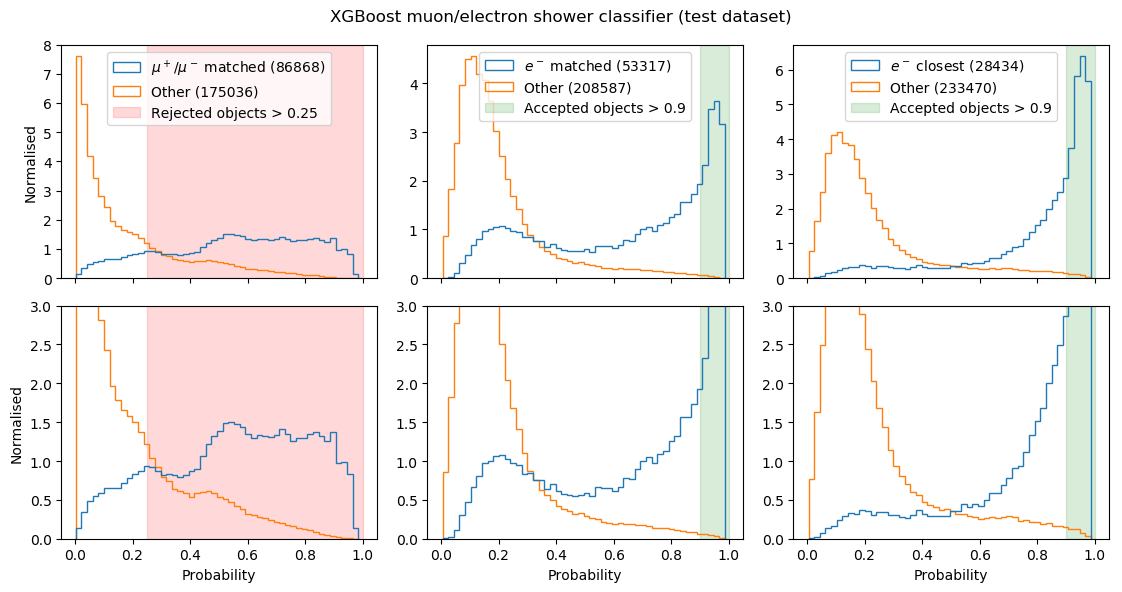

In [30]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r'XGBoost muon/electron shower classifier (test dataset)')
N=50
muon_cut = 0.25
electron_cut=0.90
close_e_cut=0.9

# Electron track classification
y_test_e = Y_test['true_e']
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron track classification
y_test_cle = Y_test['true_e_cl']
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon track classification
y_test_mu = Y_test['true_mu']
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')
label_cl_e=(r'$e^-$ closest ('+str(len(arr_cl_e))+')','Other ('+str(len(arr_cl_ne))+')')


ax[0][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[0][0].set_ylabel('Normalised')


ax[1][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[1][0].set_ylim(0,3)
ax[1][0].set_ylabel('Normalised')
ax[1][0].set_xlabel('Probability')

ax[0][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)

ax[1][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,3)
ax[1][1].set_xlabel('Probability')


ax[0][2].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[0][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)

ax[1][2].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,3)
ax[1][2].set_xlabel('Probability')

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][2].get_legend_handles_labels()
ax[0][2].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('../Output/XGB_shower.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged shower and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged showers.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of electron tagged shower and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-electron tagged showers.')

print('Cut value:',close_e_cut,'keeps', sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),'% of closest electron tagged shower and',
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),'% of not-closest-electron tagged showers.')
